In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

USE_GPU = True
dtype = torch.float32 # We will be using float

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 1000
print('using device:', device)

using device: cuda


In [2]:
# Define the path to the dataset
#dataset_path = "../../../sign_datasets/sign-language-gesture-images-dataset/Gesture Image Data"
dataset_path = "../../../sign_datasets/hagrid-classification-512p"

# Define the batch size
batch_size = 32

# Load the dataset without transformations
dataset = datasets.ImageFolder(root=dataset_path)

# Get the total number of samples
total_samples = len(dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Print the sizes of each split
print(f"Total samples: {total_samples}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Total samples: 507050
Training set size: 354935
Validation set size: 101410
Test set size: 50705


In [3]:
# Already computed mean and std
# sign-language-gesture-images-dataset/Gesture Image Data"
# computed_mean = [0.5273298025131226, 0.4507707953453064, 0.4120909869670868]
# computed_std = [0.5632718205451965, 0.5085217952728271, 0.48751917481422424]

# Hagrid
computed_mean = [0.5778126, 0.516726, 0.48417425]
computed_std = [0.25172076, 0.24928826, 0.24764916]

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to X,Y if necessary
    transforms.ToTensor(),       # Convert images to PyTorch tensors
    transforms.Normalize(mean=computed_mean, std=computed_std)  # Normalize
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get class names
class_names = dataset.classes
print("Class names:", class_names)

# Example of iterating through the train DataLoader
for images, labels in train_loader:
    print("Train Batch - Images shape:", images.shape)
    print("Train Batch - Labels shape:", labels.shape)
    break

# Print dataset sizes for verification
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

len_train_loader = len(train_loader)
len_val_loader = len(val_loader)
len_test_loader = len(test_loader)

# Print DataLoader sizes for verification
print(f"Train DataLoader size: {len(train_loader)}")
print(f"Validation DataLoader size: {len(val_loader)}")
print(f"Test DataLoader size: {len(test_loader)}")

Class names: ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']
Train Batch - Images shape: torch.Size([32, 3, 512, 512])
Train Batch - Labels shape: torch.Size([32])
Train set size: 354935
Validation set size: 101410
Test set size: 50705
Train DataLoader size: 11092
Validation DataLoader size: 3170
Test DataLoader size: 1585


In [4]:
# Access the first image in the dataset
image, label = train_loader.dataset[0]

# Extract dimensions
width = image.shape[1]
height = image.shape[2]

print(f"Width: {width}, Height: {height}")

Width: 512, Height: 512


In [5]:
def check_accuracy_part(loader, model, return_acc=False):

    # Determine the split type
    if len(loader) == len_train_loader:
        split = 'train'
    elif len(loader) == len_val_loader:
        split = 'val'
    elif len(loader) == len_test_loader:
        split = 'test'

    print(f'Checking accuracy on the {split} set')

    # Init counters and placeholders
    num_correct = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    # Set model to evaluation mode
    model.eval()

    # Disable gradient computation as we don't train
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move to device, e.g., GPU
            y = y.to(device=device, dtype=torch.long)  # Use torch.long for labels

            # Forward pass
            scores = model(x)
            _, preds = scores.max(1)  # Get predicted class -> highest score

            # Collect all predictions and labels for confusion matrix
            all_preds.append(preds.cpu())  # Append to list, move to CPU for numpy
            all_labels.append(y.cpu())    # Append to list, move to CPU for numpy

            # Count correct predictions and total samples
            correct_predictions = preds == y  # True if correct - False otherwise
            num_correct += correct_predictions.sum().item()
            num_samples += preds.size(0)

    # Compute accuracy
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

    # For test set: plot confusion matrix
    if split == 'test':
        all_preds = torch.cat(all_preds).numpy()  # Flatten and convert to numpy
        all_labels = torch.cat(all_labels).numpy()

        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Plot confusion matrix
        plt.figure(figsize=(20, 20))
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            cmap='Greens',
            linewidths=0.5,
            xticklabels=dataset.classes,
            yticklabels=dataset.classes
        )
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix with Actual Class Labels')
        plt.show()

    if return_acc:
        return 100 * acc

In [6]:
def train_part(model, optimizer, epochs=1, scheduler = None, return_acc = False, check_train_set = False, check_test_set = False):
    
    # List to store validation and train accuracies at each epoch where needed
    val_accs = []
    train_accs = []
    losses = []

    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(val_loader, model)
                print()
        
        # Step the scheduler after each epoch to adjust the learning rate if needed
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # If the scheduler is of type ReduceLROnPlateau, use validation loss for adjustment
                model.eval()  # Set model to evaluation mode
                val_loss = 0.0  # Initialize validation loss accumulator
                with torch.no_grad():  # No need to compute gradients during validation
                    for data, target in val_loader:
                        data, target = data.to(device=device, dtype=dtype), target.to(device=device, dtype=torch.long)
                        output = model(data)
                        loss = F.cross_entropy(output, target)
                        val_loss += loss.item()  # Accumulate the validation loss

                val_loss /= len(val_loader)  # Average the validation loss
                scheduler.step(val_loss)  # Step the scheduler based on the validation loss
            else:
                scheduler.step()  # Step the scheduler for other types of schedulers

        # After each epoch, check accuracies
        val_acc = check_accuracy_part(val_loader, model, return_acc=True)
        val_accs.append(val_acc)
        losses.append(loss.item())
        print(f"Validation Accuracy after epoch {e+1}: {val_acc:.2f}%")
        
        # Return accuracies if requested
        if check_train_set:
            train_acc = check_accuracy_part(train_loader, model, return_acc=True)
            train_accs.append(train_acc)
            print(f"Training Accuracy after epoch {e+1}: {train_acc:.2f}%")

    # Return accuracies if requested
    if return_acc:
        if check_train_set and check_test_set:
            test_acc = check_accuracy_part(test_loader, model, return_acc=True)  # Check test set accuracy
            return val_accs, train_accs, test_acc, losses  # Return the most recent validation accuracy and the test accuracy
        if check_train_set:  # If requested, return both validation and training accuracies
            return val_accs, train_accs, losses
        if check_test_set:  # If requested, return the validation accuracy and test accuracy
            test_acc = check_accuracy_part(test_loader, model, return_acc=True)  # Check test set accuracy
            return val_accs, test_acc, losses  # Return the most recent validation accuracy and the test accuracy
        return val_accs, losses  # Return only validation accuracies if no other set (train or test) is specified

In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [ ]:
hidden_layer_size = 500
learning_rate = 1e-3
num_classes = len(class_names)

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * width * height, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, num_classes),
)

model = model.to(device=device)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

val_accs, train_accs, test_acc, losses = train_part(model, optimizer,epochs=2, return_acc=True, check_train_set = True, check_test_set = True)


# Print the validation and test accuracies
print()
print('########### Final Results ###########')
print("Validation Accuracy:", val_accs[-1])
print("Test Accuracy:", test_acc)

Iteration 0, loss = 2.9680
Checking accuracy on the val set
Got 6439 / 101410 correct (6.35%)

Iteration 1000, loss = 3.4787
Checking accuracy on the val set
Got 12499 / 101410 correct (12.33%)

Iteration 2000, loss = 3.2010
Checking accuracy on the val set
Got 13006 / 101410 correct (12.83%)

Iteration 3000, loss = 3.5481
Checking accuracy on the val set


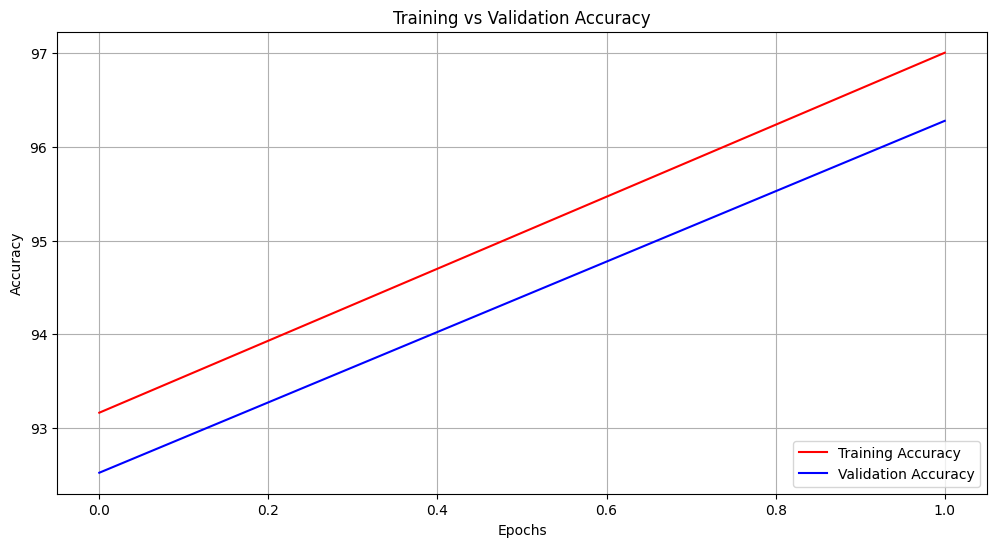

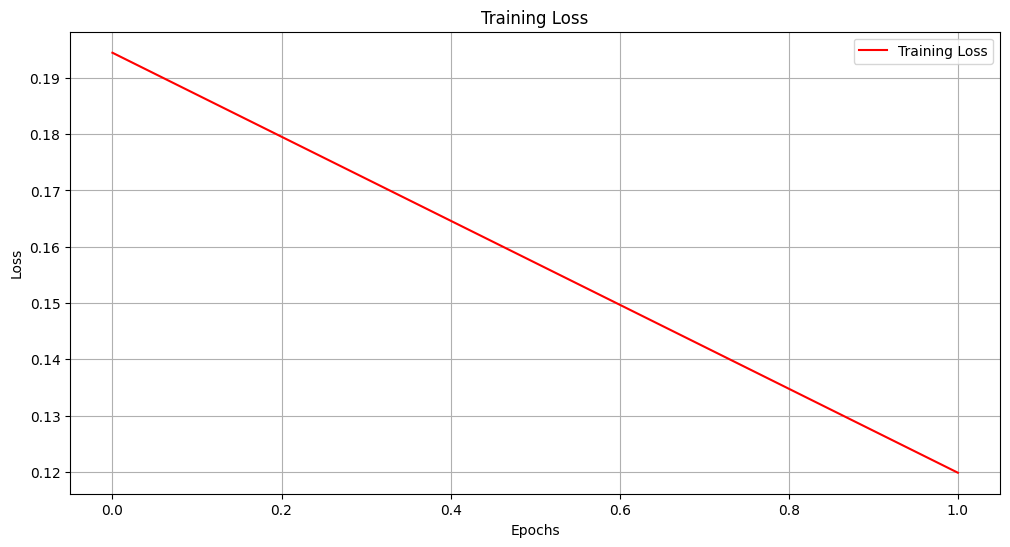

In [26]:
# Plot accuracy
epochs = range(len(val_accs))
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accs, 'r', label='Training Accuracy')
plt.plot(epochs, val_accs, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, losses, 'r', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
#plt.title('Training vs Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [6]:
model = torch.load('model.pth')  # Load the entire model

# Move the model to device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

/tmp/ipykernel_2080331/2237739796.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')  # Load the entire model


Sequential(
  (0): Flatten()
  (1): Linear(in_features=7500, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=37, bias=True)
)

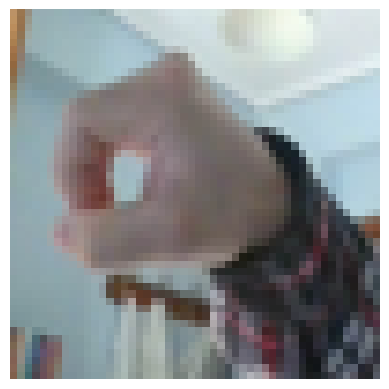

In [30]:
# Path to the image
#image_path = "../../sign_datasets/sign-language-gesture-images-dataset/Gesture Image Data/S/67.jpg"
#image_path = "../../sign_datasets/sign-language-gesture-images-dataset/Gesture Image Pre-Processed Data/S/67.jpg"
image_path = "../../sign_datasets/custom-dataset/0/0.jpg"

# Define the transformations (same as during training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=computed_mean, std=computed_std)
])

# Load the image
image = Image.open(image_path)
image = image.convert("RGB")  # Ensure 3-channel RGB
image = image.resize((50, 50))  # Resize to match the input size if necessary

# Plot the resized image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

# Apply the transformations
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

In [31]:
# Perform inference
with torch.no_grad():
    output = model(input_tensor)  # Raw scores (logits)
    predicted_idx = torch.argmax(output, dim=1).item()  # Get the index of the highest logit
    predicted_class = class_names[predicted_idx]  # Map to class name

print(f"Predicted class: {predicted_class}")

Predicted class: J
